### ResNet在fashion-mnist数据集上的测试结果

In [1]:
import time
import sys
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets


### 1 加载数据集，并作标准化处理

In [2]:
# 定义加载数据集的函数
def load_data_fashion_mnist(batch_size, root='./data', use_normalize=False, mean=None, std=None):
    """Download the fashion mnist dataset and then load into memory."""

    if use_normalize:
        normalize = transforms.Normalize(mean=[mean], std=[std])
        train_augs = transforms.Compose([transforms.RandomCrop(28, padding=2),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(), 
                    normalize])
        test_augs = transforms.Compose([transforms.ToTensor(), normalize])
    else:
        train_augs = transforms.Compose([transforms.ToTensor()])
        test_augs = transforms.Compose([transforms.ToTensor()])
    
    mnist_train = torchvision.datasets.FashionMNIST(root=root, train=True, download=True, transform=train_augs)
    mnist_test = torchvision.datasets.FashionMNIST(root=root, train=False, download=True, transform=test_augs)
    if sys.platform.startswith('win'):
        num_workers = 0  # 0表示不用额外的进程来加速读取数据
    else:
        num_workers = 4
    train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_iter, test_iter


print('计算数据集均值标准差')
batch_size = 64  
train_iter, test_iter = load_data_fashion_mnist(batch_size, root='./data', use_normalize=False)
# 求整个数据集的均值
temp_sum = 0
cnt = 0
for X, y in train_iter:
    if y.shape[0] != batch_size:
        break   # 最后一个batch不足batch_size,这里就忽略了
    channel_mean = torch.mean(X, dim=(0,2,3))  # 按channel求均值(不过这里只有1个channel)
    cnt += 1   # cnt记录的是batch的个数，不是图像
    temp_sum += channel_mean[0].item()
dataset_global_mean = temp_sum / cnt
print('整个数据集的像素均值:{}'.format(dataset_global_mean))
# 求整个数据集的标准差
cnt = 0
temp_sum = 0
for X, y in train_iter:
    if y.shape[0] != batch_size:
        break   # 最后一个batch不足batch_size,这里就忽略了
    residual = (X - dataset_global_mean) ** 2
    channel_var_mean = torch.mean(residual, dim=(0,2,3))  
    cnt += 1   # cnt记录的是batch的个数，不是图像
    temp_sum += math.sqrt(channel_var_mean[0].item())
dataset_global_std = temp_sum / cnt
print('整个数据集的像素标准差:{}'.format(dataset_global_std))


# 重新获取应用了归一化的数据集迭代器
batch_size = 64  # 改大一点 跑得更快
train_iter, test_iter = load_data_fashion_mnist(batch_size, root='./data', use_normalize=True,
                        mean = dataset_global_mean, std = dataset_global_std)

计算数据集均值标准差
整个数据集的像素均值:0.28603588981333256
整个数据集的像素标准差:0.35291416328833175


### 2 网络结构

**AlexNet**

In [20]:
# 定义网络结构
class AlexNet(nn.Module):
    
    def __init__(self, num_channels=3, num_classes=1000):
        super(AlexNet, self).__init__()
        # 由于Fashion-MNIST为28x28， 而最初AlexNet的输入图片是227x227的。所以网络层数和参数需要调节
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),  # inplace = True  为了省空间
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
            )
        self.avgpool = nn.AdaptiveAvgPool2d((3, 3))
        self.fc = nn.Sequential(
            nn.Linear(256*3*3, 1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            nn.Linear(1024,512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            nn.Linear(512,10)
            )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.fc(x.view(x.size(0), -1))  # x = x.view(-1, 256 * 3 * 3)
        return x

**ResNet**

In [37]:
####network
class Residual(nn.Module):
    def __init__(self,in_channels,out_channels,use_conv1x1=False,strides=1):
        super(Residual,self).__init__()
        self.relu=nn.ReLU(inplace=True)
        self.bn1=nn.BatchNorm2d(in_channels,eps=1e-3)
        self.conv1=nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,stride=strides)
        self.bn2=nn.BatchNorm2d(out_channels,eps=1e-3)
        self.conv2=nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1)
        if use_conv1x1:
            self.conv3=nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=strides)
        else:
            self.conv3=None


    def forward(self, x):
        y = self.relu(self.conv1(self.bn1(x)))
        y = self.relu(self.conv2(self.bn2(y)))
        if self.conv3:
            x=self.conv3(x)
        return self.relu(x + y)


def ResNet_block(in_channels,out_channels,num_residuals,first_block=False):
    layers=[]
    for i in range(num_residuals):
        if i==0 and not first_block:
            layers+=[Residual(in_channels,out_channels,use_conv1x1=True,strides=2)]
        elif i>0 and not first_block:
            layers+=[Residual(out_channels,out_channels)]
        else:
            layers += [Residual(in_channels, out_channels)]
    blk=nn.Sequential(*layers)
    return blk


class GlobalAvgPool2d(nn.Module):
    """
    全局平均池化层
    可通过将普通的平均池化的窗口形状设置成输入的高和宽实现
    """
    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()
    def forward(self, x):
        return F.avg_pool2d(x, kernel_size=x.size()[2:])

    
# class FlattenLayer(torch.nn.Module):
#     def __init__(self):
#         super(FlattenLayer, self).__init__()
#     def forward(self, x): # x shape: (batch, *, *, ...)
#         return x.view(x.shape[0], -1)
    
    
class ResNet(nn.Module):
    def __init__(self,in_channel,num_classes):
        super(ResNet,self).__init__()
        self.block1=nn.Sequential(nn.Conv2d(in_channels=in_channel,out_channels=32,kernel_size=3,stride=1,padding=1),#  更改原来的大小
                                  nn.BatchNorm2d(32),
                                  nn.ReLU())
#                                   nn.ReLU(),
#                                   nn.MaxPool2d(kernel_size=3,stride=2,padding=1))  # 去掉maxpool缩小感受野
        self.block2=nn.Sequential(ResNet_block(32,32,2,True),
                                  ResNet_block(32,64,2),
                                  ResNet_block(64,128,2),
                                  ResNet_block(128,256,2))
#         self.block3=nn.Sequential(nn.AvgPool2d(kernel_size=3))
        self.block3=nn.Sequential(GlobalAvgPool2d())
#         self.Dense = nn.Sequential(FlattenLayer(),
#                                   nn.Linear(256,num_classes))
        self.Dense=nn.Linear(256,10)


    def forward(self,x):
        y=self.block1(x)
        y=self.block2(y)
        y=self.block3(y)
        y=y.view(-1,256)
        y=self.Dense(y)
        return y

### 3 训练

In [32]:
# 计算准确率
def compute_accuracy(loader, net, device):
    total_accu = 0.0
    num = 0

    for i, data in enumerate(loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = net.forward(inputs)
        predicted = torch.argmax(outputs, dim=1)
        total_accu += torch.mean((predicted == labels).float()).item()
        num += 1
    return total_accu / num

# 定义训练函数
def train_model(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs):
    train_acc_list = list()
    test_acc_list = list()
    loss_list = list()
    
    net = net.to(device)
    print("training on ", device)
    loss = torch.nn.CrossEntropyLoss()
    best_test_acc = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, batch_count, start = 0.0, 0.0, 0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        
        train_acc = compute_accuracy(train_iter, net, device)
        test_acc = compute_accuracy(test_iter, net, device)
        loss_list.append(train_l_sum / batch_count)   # 便于后续可视化看看损失函数值
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        print('epoch %d, loss %.4f, train acc %.4f, test acc %.4f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))
        if test_acc > best_test_acc:
            print('find best! save at model/best.pth')
            best_test_acc = test_acc
            torch.save(net.state_dict(), 'model/best.pth')
            
    return loss_list, train_acc_list, test_acc_list

**AlexNet训练**

In [22]:
print('训练...')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lr, num_epochs = 0.01, 50
net = AlexNet(num_channels=1, num_classes=10).to(device)
#optimizer = optim.Adam(net.parameters(), lr=lr)
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)   
loss_list,train_acc_list,test_acc_list = train_model(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

训练...
training on  cuda:0
epoch 1, loss 0.6285, train acc 0.7693, test acc 0.8408, time 41.8 sec
find best! save at model/best.pth
epoch 2, loss 0.4027, train acc 0.8521, test acc 0.8671, time 41.1 sec
find best! save at model/best.pth
epoch 3, loss 0.3478, train acc 0.8745, test acc 0.8668, time 40.1 sec
epoch 4, loss 0.3202, train acc 0.8830, test acc 0.8838, time 40.9 sec
find best! save at model/best.pth
epoch 5, loss 0.2990, train acc 0.8900, test acc 0.8956, time 40.3 sec
find best! save at model/best.pth
epoch 6, loss 0.2833, train acc 0.8961, test acc 0.8918, time 39.7 sec
epoch 7, loss 0.2715, train acc 0.9014, test acc 0.8993, time 41.2 sec
find best! save at model/best.pth
epoch 8, loss 0.2652, train acc 0.9032, test acc 0.9025, time 40.3 sec
find best! save at model/best.pth
epoch 9, loss 0.2568, train acc 0.9060, test acc 0.9020, time 39.8 sec
epoch 10, loss 0.2512, train acc 0.9083, test acc 0.9074, time 40.9 sec
find best! save at model/best.pth
epoch 11, loss 0.2454, tr

**ResNet训练**

In [38]:
print('训练...')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lr, num_epochs = 0.01, 50
net = ResNet(1, 10).to(device)
#optimizer = optim.Adam(net.parameters(), lr=lr)
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)   
loss_list,train_acc_list,test_acc_list = train_model(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

训练...
training on  cuda:0
epoch 1, loss 0.5831, train acc 0.7811, test acc 0.8679, time 73.0 sec
find best! save at model/best.pth
epoch 2, loss 0.3306, train acc 0.8790, test acc 0.8937, time 72.4 sec
find best! save at model/best.pth
epoch 3, loss 0.2876, train acc 0.8945, test acc 0.9071, time 72.8 sec
find best! save at model/best.pth
epoch 4, loss 0.2580, train acc 0.9065, test acc 0.9100, time 73.7 sec
find best! save at model/best.pth
epoch 5, loss 0.2401, train acc 0.9129, test acc 0.9137, time 73.8 sec
find best! save at model/best.pth
epoch 6, loss 0.2306, train acc 0.9152, test acc 0.9090, time 74.9 sec
epoch 7, loss 0.2176, train acc 0.9207, test acc 0.9175, time 74.8 sec
find best! save at model/best.pth
epoch 8, loss 0.2078, train acc 0.9237, test acc 0.9195, time 74.8 sec
find best! save at model/best.pth
epoch 9, loss 0.2021, train acc 0.9265, test acc 0.9203, time 73.6 sec
find best! save at model/best.pth
epoch 10, loss 0.1957, train acc 0.9287, test acc 0.9246, time 

In [ ]:
# 统计网络参数量
    
def get_parameter_number(net):
    total_num = sum(p.numel() for p in net.parameters())
    trainable_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    return {'Total': total_num, 'Trainable': trainable_num}

print('打印 1*1*28*28 输入经过每个模块后的shape')
X = torch.rand((1, 1, 28, 28))
for name, layer in net.named_children():
    X = layer(X)
    print(name, ' output shape:\t', X.shape)
    
print('网络参数量为：')
get_parameter_number(net)

In [24]:
print('加载最优模型')
net.load_state_dict(torch.load('model/best.pth'))
net = net.to(device)


print('inference测试集')
net.eval() 
id = 0
preds_list = []
with torch.no_grad():
    for X, y in test_iter:
        batch_pred = list(net(X.to(device)).argmax(dim=1).cpu().numpy())
        for y_pred in batch_pred:
            preds_list.append((id, y_pred))
            id += 1
            
print('生成提交结果文件')
with open('submission_ResNet_01.csv', 'w') as f:
    f.write('ID,Prediction\n')
    for id, pred in preds_list:
        f.write('{},{}\n'.format(id, pred))

加载最优模型
inference测试集
生成提交结果文件


### 4 可视化

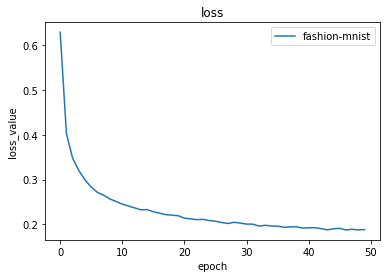

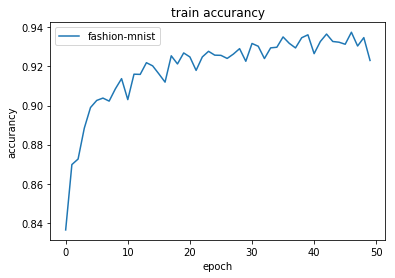

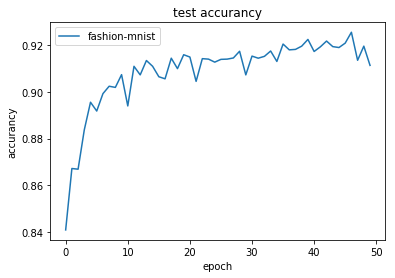

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def draw(fashion_list, xlabel,ylabel,title):
    fig=plt.figure()
    x = list(range(50))
    
    plt.plot(x, fashion_list, label='fashion-mnist')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

draw(loss_list, 'epoch','loss_value','loss')
draw(train_acc_list, 'epoch','accurancy','train accurancy')
draw(test_acc_list,  'epoch','accurancy','test accurancy')